In [6]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkFiles
import pandas as pd
import numpy as np
from transformers import BertTokenizer, AutoTokenizer
import seaborn as sn
import matplotlib.pyplot as plt
from datasets import Dataset
from datasets import load_dataset
from pyspark.sql import SparkSession
from pyspark.sql.functions import length


In [2]:
import os
import sys
from dotenv import load_dotenv

#For Desktop 
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

from huggingface_hub import login

#For Desktop
login(token=os.getenv("HF_MASTER_KEY"))

#For Macbook
#load_dotenv()
#login(token=os.getenv("MACBOOK_HF_KEY"))

# Clear conflicting environment variables
#if 'PYTHONPATH' in os.environ:
    #del os.environ['PYTHONPATH']



In [3]:
from pyspark.sql import SparkSession
from datasets import load_dataset
import pandas as pd

# Test run with Reuters and Ashraq financial news dataset
reuters_spark = SparkSession.builder.appName("ReutersNews").getOrCreate()
finnews_spark = SparkSession.builder.appName('FinNews').getOrCreate()

# Dictionary mapping spark sessions to dataset names
spark_dataset_mapping = {
    reuters_spark: "danidanou/Reuters_Financial_News",
    finnews_spark: "ashraq/financial-news-articles"
}

def ds_to_spark(spark_session, dataset_name, dataset_size=10000):
    """
    Convert a HuggingFace dataset to a Spark DataFrame
    
    Args:
        spark_session: Active Spark session
        dataset_name: HuggingFace dataset name/path
        dataset_size: Number of rows to load (default: 10000)
    
    Returns:
        Spark DataFrame or None if failed
    """
    from pyspark.sql.types import StructType, StructField, StringType
    
    print(f"Loading dataset: {dataset_name}")
    
    try:
        # Load HuggingFace dataset with size limit
        hf_df = load_dataset(dataset_name, split=f'train[:{dataset_size}]')
        
        # Convert to pandas
        pd_df = hf_df.to_pandas()
        
        print(f"DF shape: {pd_df.shape}")
        
        # Check and clean columns
        for col in pd_df.columns:
            if pd_df[col].dtype == 'object':
                # Get a sample of non-null values
                non_null_values = pd_df[col].dropna()
                
                if len(non_null_values) > 0:
                    # Check the first few values to determine type
                    sample_value = non_null_values.iloc[0]
                    
                    if isinstance(sample_value, (list, dict)):
                        # Convert complex types to string
                        pd_df[col] = pd_df[col].apply(lambda x: str(x) if x is not None else "")
                        print(f"Converted col '{col}' to string")
        
        # Fill null values
        pd_df = pd_df.fillna("")
        
        try:
            # Convert pandas DataFrame to list of Row objects for compatibility
            records = pd_df.to_dict('records')
            spark_df = spark_session.createDataFrame(records)
            print(f"Successfully created Spark DataFrame for {dataset_name}")
            print("Schema:")
            spark_df.printSchema()
            return spark_df
            
        except Exception as e:
            print(f"Error creating DataFrame for {dataset_name}: {e}")
            
            # Alternative approach: Define explicit schema and use records
            print("Trying with explicit string schema and records conversion...")
            
            try:
                # Create schema with all string types
                string_schema = StructType([
                    StructField(col, StringType(), True) for col in pd_df.columns
                ])
                
                # Convert all columns to string
                pd_df_str = pd_df.astype(str)
                
                # Convert to records format
                records = pd_df_str.to_dict('records')
                
                # Create Spark DataFrame with explicit schema
                spark_df = spark_session.createDataFrame(records, schema=string_schema)
                print(f"Successfully created Spark DataFrame with string schema for {dataset_name}")
                print("Schema:")
                spark_df.printSchema()
                return spark_df
                
            except Exception as e2:
                print(f"Failed even with string schema and records: {e2}")
                
                # Last resort: Manual row creation
                print("Trying manual row creation...")
                try:
                    from pyspark.sql import Row
                    
                    # Create Row objects manually
                    Row = Row(*pd_df.columns)
                    rows = [Row(*[str(val) for val in row]) for row in pd_df.values]
                    
                    spark_df = spark_session.createDataFrame(rows)
                    print(f"Successfully created Spark DataFrame with manual row creation for {dataset_name}")
                    print("Schema:")
                    spark_df.printSchema()
                    return spark_df
                    
                except Exception as e3:
                    print(f"All methods failed for {dataset_name}: {e3}")
                    return None
    
    except Exception as e:
        print(f"Error loading dataset {dataset_name}: {e}")
        return None



----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 61201)
Traceback (most recent call last):
  File "c:\Users\Omar\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "c:\Users\Omar\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "c:\Users\Omar\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "c:\Users\Omar\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 747, in __init__
    self.handle()
  File "C:\spark\spark-3.5.6-bin-hadoop3\python\pyspark\accumulators.py", line 295, in handle
    poll(accum_updates)
  File "C:\spark\spark-3.5.6-bin-hadoop3\python\pyspark\accumulators.py", line 267, in poll
    if self

In [28]:
from datasets import load_dataset
reuters_df = load_dataset("danidanou/Reuters_Financial_News")['train'].to_pandas()
finnews_df = load_dataset("ashraq/financial-news-articles")['train'].to_pandas()

reuters_df = reuters_df.rename(columns={
    'Article': 'text',
    'Link': 'url',
    'Headline': 'title'
    })

reuters_df = reuters_df.drop(columns=['Journalists', 'Date', '__index_level_0__', 'Summary'])

#Merging the df
merged_df = pd.concat([reuters_df, finnews_df])

#Shuffling the rows
merged_df = merged_df.sample(frac=1).reset_index(drop=True)




merged_df['text_length'] = merged_df['text'].apply(lambda text: len(text))
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411601 entries, 0 to 411600
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   title        411601 non-null  object
 1   url          411601 non-null  object
 2   text         411601 non-null  object
 3   text_length  411601 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 12.6+ MB


In [31]:
merged_df.text.head(10)

0    May 11, 2018 / 5:43 PM / Updated an hour ago U...
1    JOHANNESBURG (Reuters) - South Africa’s ruling...
2     "The European Council underlines the need to ...
3    March 7 (Reuters) - Hub International Ltd:\n* ...
4    March 6 (Reuters) - Kimura Co Ltd\n* Says it w...
5     The company also said the World Trade Organiz...
6    January 16, 2018 / 8:13 PM / Updated 23 minute...
7    Jan 17 (Reuters) - Pros Holdings Inc:\n* CONES...
8    Feb 8 (Reuters) - Page Industries Ltd:\n* DEC ...
9    JERSEY CITY, N.J., Feb. 22, 2018 (GLOBE NEWSWI...
Name: text, dtype: object

In [ ]:
#reuters_df = ds_to_spark(reuters_spark, "danidanou/Reuters_Financial_News", 30000)
#finnews_df = ds_to_spark(finnews_spark, "ashraq/financial-news-articles", 30000)

# Check if successful
#if reuters_df:
    #print("Reuters dataset loaded successfully")
    #reuters_df.show(5)

#if finnews_df:
    #print("Financial News dataset loaded successfully") 
    #finnews_df.show(5)

Loading dataset: danidanou/Reuters_Financial_News
DF shape: (30000, 7)
Error creating DataFrame for danidanou/Reuters_Financial_News: [CANNOT_INFER_TYPE_FOR_FIELD] Unable to infer the type of the field `Journalists`.
Trying with explicit string schema and records conversion...
Successfully created Spark DataFrame with string schema for danidanou/Reuters_Financial_News
Schema:
root
 |-- Headline: string (nullable = true)
 |-- Journalists: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Link: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Article: string (nullable = true)
 |-- __index_level_0__: string (nullable = true)

Loading dataset: ashraq/financial-news-articles
DF shape: (30000, 3)
Successfully created Spark DataFrame for ashraq/financial-news-articles
Schema:
root
 |-- text: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)

Reuters dataset loaded successfully
+--------------------+------------

<Figure size 2400x600 with 0 Axes>

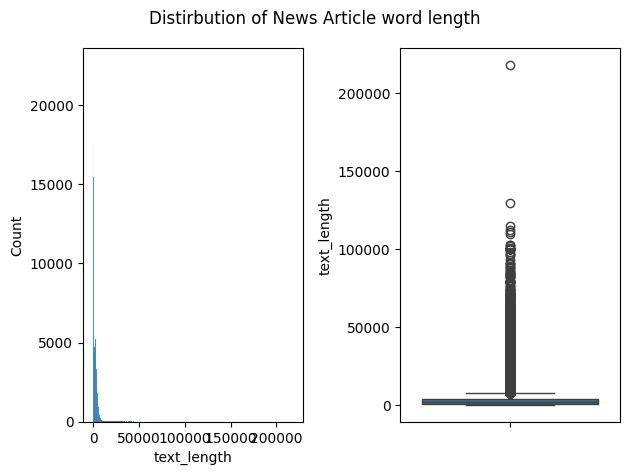

In [25]:

plt.figure(figsize=(24,6))

fig, axs = plt.subplots(ncols=2)



fig.suptitle('Distirbution of News Article word length')

sn.histplot(data=merged_df['text_length'], ax=axs[0])

sn.boxplot(data=merged_df['text_length'], ax=axs[1])
plt.tight_layout()
plt.show()

In [29]:
merged_df["text_length"].describe()

count    411601.000000
mean       2606.701626
std        4176.968322
min           0.000000
25%         534.000000
50%        1786.000000
75%        3293.000000
max      218108.000000
Name: text_length, dtype: float64

In [33]:
#We'll do 3 methods the first will be to take the first 512 words of an article (if it has it), combine into a column for a dataframe
#The second method will be to take the middle 512 words (if available) of an article and combine into a column
#The third will be to take the first 2000 words of an article, combine into a column 

from pyspark.sql.functions import substring, col, expr
from pyspark.sql.types import IntegerType



#Method one
first_512_df = merged_df[merged_df['text_length'] >= 512]

#Method two

#Making a function to define middle of column

middle_512_df = merged_df['text'].apply(
    lambda text: text[int((len(text) - 512) / 2):int(len(text) - (len(text) - 512) / 2)]
)

#Third_method
first_4096_df = merged_df[merged_df["text_length"] >= 4096]





In [34]:
#The third method will feed into a longform tranfsformer for pretraining
#The second method and first method will feed into a DistilBERT for pretraining
#We'll use a one lstm that will train on the first 512 words (benchmark, to be added later)


#Bert tokenizer

bert_tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')
lf_tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')


(06/17/25)
The step below could use optimzation 

In [37]:
datasets_pd

{'first_512':                                                     title  \
 0       English County Championship Division Two Score...   
 1       South Africa's ANC gives Zuma 48 hours to resi...   
 2       EU leaders to urge fast work on EU budget rule...   
 5       Boeing blasts EADS effort to extend tanker dea...   
 6       'The Fakeys': Comedians turn tables on Trump's...   
 ...                                                   ...   
 411592                                     World Rankings   
 411594  Cricket-Morgan hopes ball-tampering bans will ...   
 411597      SEC may seek more disclosure by credit raters   
 411598  Apple battles U.S. over scope of e-books injun...   
 411599  Argentina defends ties with China, Russia desp...   
 
                                                       url  \
 0       https://in.reuters.com/article/cricket-england...   
 1       https://www.reuters.com/article/us-safrica-pol...   
 2       http://www.reuters.com/article/2010/09/11/us-e

In [ ]:
datasets_pd = {
    'first_512': first_512_df,
    'middle_512': middle_512_df, 
    'first_4096': first_4096_df
}

    
# Tokenize
datasets_hf = {
    name: Dataset.from_pandas(df) 
    for name, df in datasets_pd.items()
}


configs = [
    {'name': 'first_512', 'tokenizer': bert_tokenizer, 'max_length': 512},
    {'name': 'middle_512', 'tokenizer': bert_tokenizer, 'max_length': 512},
    {'name': 'first_4096', 'tokenizer': lf_tokenizer, 'max_length': 4096}
]


tokenized_datasets = {}


for config in configs:
    tokenized_datasets[config['name']] = datasets_hf[config['name']].map(
        lambda examples: config['tokenizer'](
            examples[config['name']],  # adjust column name as needed
            truncation=True,
            padding='max_length',
            max_length=config['max_length'],
            return_tensors='pt'
        ),
        batched=True
    )

KeyError: 'text'

In [ ]:
for dataset in tokenized_datasets.keys():
    tokenized_datasets[dataset].push_to_hub(f"Czunzun/Financial_news_{dataset}")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/33 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/33 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

In [15]:
169826664 > 35833704

True